# Slendr simulations

This notebook contains the simulations produced with *slendr* for the spaceNNtime project. 

<a name="Home"></a>

## Contents

0. [ Library and packages ](#Lib)
1. [ Functions ](#Fun)
    + 1. [Python Functions](#Pyf)
    + 2. [R Functions](#Rfu)
2. [ Slendr - european pop history, single locus and temporal uniform sampling ](#Sle)
    + 1. [ Setup map and regions ](#Map)
    + 2. [ Setup populations, their demographic history and admixtures ](#Pop)
    + 3. [ Compile the model ](#Com)
    + 4. [ Explore the model ](#Exp)
    + 5. [ Sampling ](#Saa)
    + 6. [ Simulate ](#Sim)
    
<a name="Lib"></a>
## 0. Library and packages

In [1]:
import sys
import pandas as pd
import numpy as np
import tskit
import msprime
import pyslim

from rpy2.robjects import r, pandas2ri

%load_ext rpy2.ipython
pandas2ri.activate()

In [2]:
%%R
.libPaths()

[1] "/home/qxz396/miniconda3/envs/spaceNNtime/lib/R/library"


In [3]:
%%R
.libPaths(c("/maps/projects/racimolab/people/qxz396/spaceNNtime/renv/library/R-4.1/x86_64-redhat-linux-gnu", "/tmp/Rtmp9Hi1cZ/renv-system-library"))

library(ggplot2)
library(cowplot)
library(slendr)
library(sf)


#library(tidyverse)

R[write to console]: Linking to GEOS 3.7.2, GDAL 3.0.4, PROJ 6.3.2



In [4]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/spaceNNtime/renv/library/R-4.1/x86_64-redhat-linux-gnu"
[2] "/home/qxz396/miniconda3/envs/spaceNNtime/lib/R/library"                                       



[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Fun"></a>
## 1. Functions

<a name="Pfu"></a>
### A. Python Functions

<a name="Rfu"></a>
### B. R Functions

In [5]:
%%R

sampling_uniform_intime <- function(n, pop_timing, pops_list, gen_time = 30, min = 500, max = 51000){
    samples  <- data.frame()
    i = 0
    while(samples %>% nrow() < 1 || sum(samples$n) < n){
        
        t = round(runif(n = 1, min = min, max = max))

        if(pop_timing %>% dplyr::filter(start > t+gen_time, end < t-gen_time) %>% nrow() > 0){
            i = i + 1
     
            pop_idx  = pop_timing %>% 
                            dplyr::filter(start > t+gen_time, end < t-gen_time) %>% 
                            dplyr::sample_n(1) %>% 
                            dplyr::pull(index)

            pop_nam  = pop_timing %>% dplyr::filter(index == pop_idx) %>% dplyr::pull(pop)

            if(samples %>% nrow() > 1 && samples %>% dplyr::filter(time  == t, pop == pop_nam) %>% nrow() > 0){
                
                samples <- samples %>% dplyr::mutate(n = ifelse(time == t & pop == pop_nam, n+1, n))
                
            }else{

                samples <- rbind(samples, sampling(model, times = t, list( pops_list[[pop_idx]], 1 )))
            }
        }
    }
    return(samples)
}

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Sle"></a>
## 2. Slendr - european pop history, single locus and temporal uniform sampling

<a name="Map"></a>
### A. Setup map and regions

OGR data source with driver: ESRI Shapefile 
Source: "/tmp/RtmppSEC5V", layer: "ne_110m_land"
with 127 features
It has 3 fields


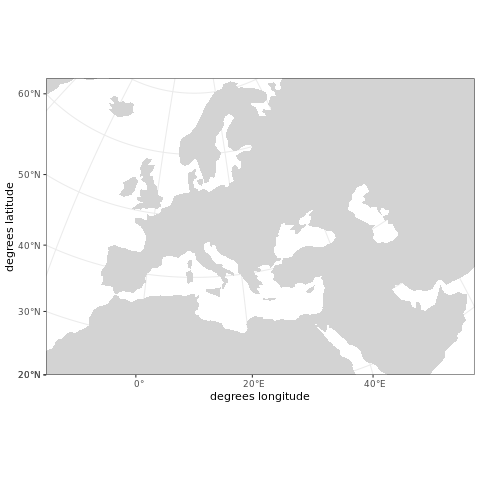

In [6]:
%%R
map <- world(xrange = c(-15, 60), yrange = c(20, 65),crs = "EPSG:3035")
plot(map)

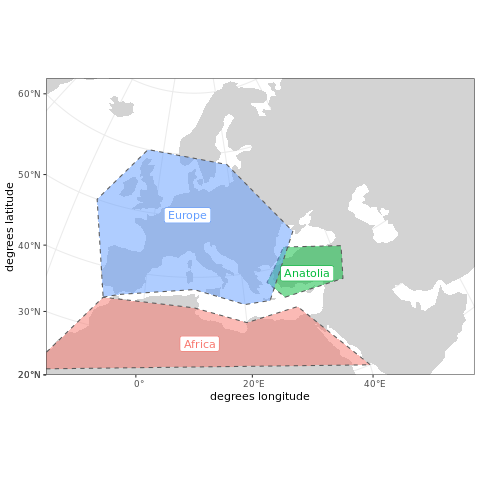

In [7]:
%%R

africa   <- region("Africa",   map, polygon = list(c(-18, 20), c(40, 20), c(30, 33),c(20, 32), c(10, 35), c(-8, 35)))
europe   <- region("Europe",   map, polygon = list(c(-8, 35), c(-5, 36), c(10, 38), c(20, 35), c(25, 35),c(33, 45), c(20, 58), c(-5, 60), c(-15, 50)))
anatolia <- region("Anatolia", map, polygon = list(c(28, 35), c(40, 35), c(42, 40), c(30, 43), c(27, 40), c(25, 38)))

plot(africa, europe, anatolia)

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Pop"></a>
### B. Setup populations, their demographic history and admixtures


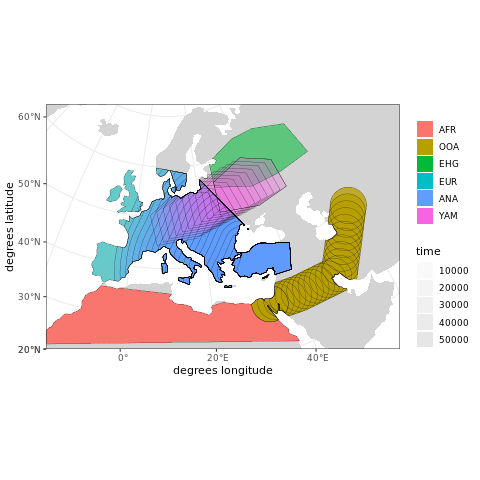

In [8]:
%%R

# African ancestral population
# ----------------------------

afr <- population( 
  "AFR", parent = "ancestor", time = 52000, N = 3000,
  map = map, polygon = africa)

# population of the first migrants out of Africa
# ----------------------------------------------

ooa <- population("OOA", parent = afr, time = 51000, N = 500, remove = 25000, center = c(33, 30), radius = 400e3) %>%
            move(trajectory = list(c(40, 30), c(50, 30), c(60, 40)), start = 50000, end = 40000, snapshots = 20)

# Eastern hunter-gatherers
# ------------------------    
    
ehg <- population("EHG", parent = ooa, time = 28000, N = 1000, remove = 6000, polygon = list(c(26, 55), c(38, 53), c(48, 53), c(60, 53), c(60, 60), c(48, 63), c(38, 63), c(26, 60)))

# European population
# -------------------

eur <- population( name = "EUR", parent = ehg, time = 25000, N = 2000, polygon = europe)

# Anatolian farmers
# -----------------

ana <- population( name = "ANA", time = 28000, N = 3000, parent = ooa, remove = 4000, center = c(34, 38), radius = 500e3, polygon = anatolia) %>%
            expand(by = 2500e3, start = 10000, end = 7000, polygon = join(europe, anatolia), snapshots = 20)

# Yamnaya steppe population
# -------------------------
    
yam <- population( name = "YAM", time = 7000, N = 500, parent = ehg, remove = 2500, polygon = list(c(26, 50), c(38, 49), c(48, 50), c(48, 56), c(38, 59), c(26, 56))) %>%
            move(trajectory = list(c(15, 50)), start = 5000, end = 3000, snapshots = 10)

# Gene flow events
# ----------------
    
gf <- list(
  geneflow(from = ana, to = yam, rate = 0.5,  start = 6500, end = 6400, overlap = FALSE),
  geneflow(from = ana, to = eur, rate = 0.5,  start = 8000, end = 6000),
  geneflow(from = yam, to = eur, rate = 0.75, start = 4000, end = 3000)
)
    
plot(afr, ooa, ehg, eur, ana, yam)



[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Com"></a>
### C. Compile the model

In [9]:
%%bash

mkdir -p /projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr

In [10]:
%%R

if(file.exists("/maps/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/populations.tsv")){
    model <- read("/maps/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr")
}else{
    model <- compile(
      populations      = list(afr, ooa, ehg, eur, ana, yam), 
      geneflow         = gf, 
      generation_time  = 30,
      resolution       = 10e3,                     # resolution in meters per pixel
      competition_dist = 130e3, mate_dist = 100e3, # spatial interaction in SLiM
      dispersal_dist   = 70e3,                     # how far will offspring end up from their parents
      dir              = "/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr", overwrite = TRUE
    )
}

model

slendr 'model' object 
--------------------- 
populations: AFR, OOA, EHG, ANA, EUR, YAM 
geneflow events: [no geneflow]
generation time: 30 
time direction: backward 
model type: spatial
  - number of spatial maps: 60 
  - resolution: 10000 distance units per pixel

configuration files in: /maps/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr 

A detailed model specification can be found in `$splits`, `$geneflows`,
`$maps`, `$populations`, and other components of the model object (for
a complete list see `names(<model object>)`). You can also examine
the serialized configuration files in the model directory.


[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Exp"></a>
### D. Explore the model

The command below `explore()` would by default open a browser. However, I added an otpion (`launchbrowser`) so that this can be prevented and istead, a link is provided (`launchbrowser = FALSE`). We can connect to that link using an **ssh tunel**. To do that:

1. run `explore(model, launchbrowser = FALSE)` in R. You will obtain a similar output than the cell below.

2. The http link has been provided. We can create a ssh tunel to connect to it by running the follwing command in a terminal in our local computer.

3. Check that the ports (numbers surrounding the "localhost" and the last digits in the link) should be the same.
4. Pate `localhost:7878` in a web browser
5. The `explore()` command can't be stopped if it's run with the `launchbrowser = FALSE` option. So, consider if you want to restart the kernel before running that function.

In [11]:
%%R

#explore(model, launchbrowser = FALSE)

NULL


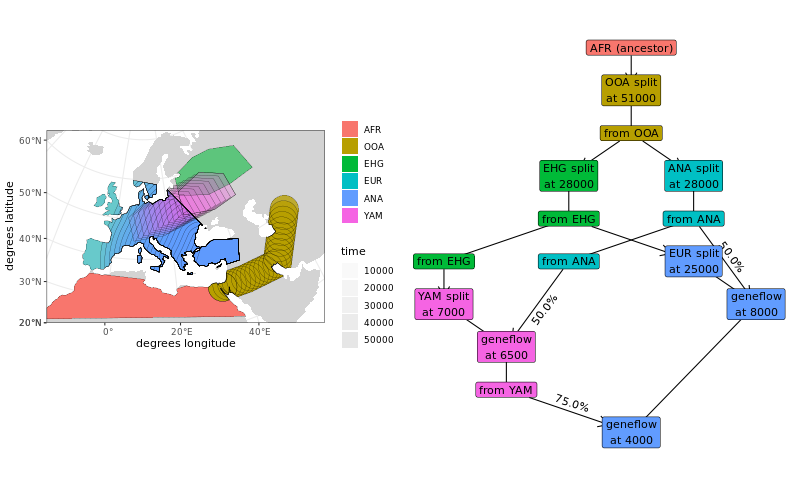

In [12]:
%%R -w 800
plot_grid(
    plot(afr, ooa, ehg, eur, ana, yam),
    plot_graph(model) + ggplot2::theme(legend.position = "none"))

In [19]:
%%bash

mkdir ../sandbox/europe/plots

In [38]:
%%R -w 800

plot(afr, ooa, ehg, eur, ana, yam) + ggplot2::theme(legend.position = "none") + xlab("Longitude (º)") + ylab("Latitude (º)")

ggsave("../sandbox/europe/plots/graph.pdf", width = 7, height = 3.5, dpi = 300, units = "in")

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Sam"></a>
### E. Sampling 

Through slendr, I'll schedule a uniform random sampling of indiviudals through time that will amount to 3,000 individuals. From this initial simulation, I'll downsample, alter the sampling strategy (exponentially random sampling) and other perturbations of the simulation to test the neural network in later steps of the pipeline.

In [71]:
%%R

set.seed(1234)

pops_list  <- list(afr, ooa, ehg, eur, ana, yam)

pop_timing <- data.frame(pop   = c("AFR", "OOA", "EHG", "EUR", "ANA", "YAM"),
                         start = c(52000, 51000, 28000, 25000, 28000,  7000),
                         end   = c(    0, 25000,  6000,     0,  4000,  2500),
                         index = c(    1,     2,     3,     4,     5,     6)) %>%
                        dplyr::filter(pop != "AFR")

samples    <- sampling_uniform_intime(1500, pop_timing, pops_list)
head(samples)

   time pop n
1  6242 YAM 1
2 31268 OOA 1
3 43976 OOA 1
4   980 EUR 1
5 34137 OOA 1
6 35526 OOA 1


In [14]:
%%R

samples %>% dplyr::summarize(sum(n))

  sum(n)
1  15000


In [15]:
%%R

samples %>% summary()

      time           pop                  n      
 Min.   :  502   Length:13639       Min.   :1.0  
 1st Qu.:12884   Class :character   1st Qu.:1.0  
 Median :24883   Mode  :character   Median :1.0  
 Mean   :25308                      Mean   :1.1  
 3rd Qu.:37718                      3rd Qu.:1.0  
 Max.   :50959                      Max.   :4.0  


In [53]:
%%R

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

colors = gg_color_hue(6)
col_pop = c("AFR" = colors[1], "OOA" = colors[2], "EHG" = colors[3],
            "ANA" = colors[4], "EUR" = colors[5], "YAM" = colors[6])


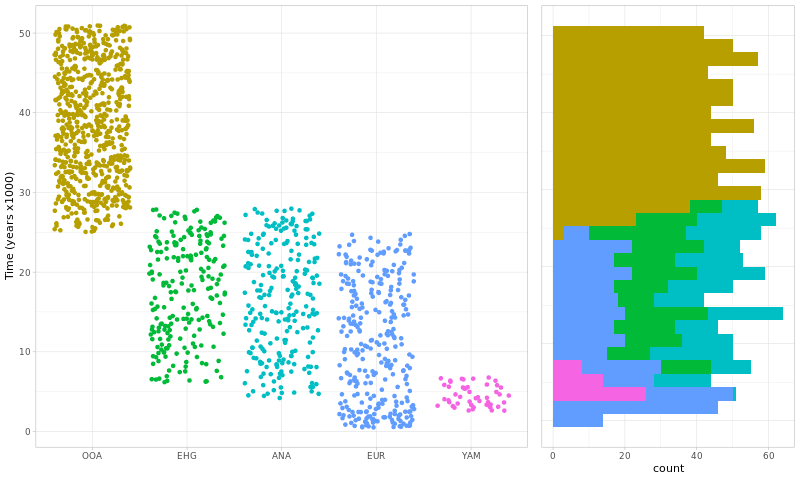

In [72]:
%%R -w 800

plot_grid(

    samples %>%
        tidyr::uncount(n) %>%
        dplyr::mutate(pop = factor(pop, levels = c("OOA", "EHG", "ANA", "EUR", "YAM"))) %>%
        ggplot() +
        geom_jitter(aes(x = pop, y = time/1000, color = pop)) +
        scale_color_manual(values=col_pop) +
        xlab("") +
        ylab("Time (years x1000)") +
        theme_light() +
        theme(legend.position = "none"),
  
    samples %>%
        tidyr::uncount(n) %>%
        ggplot() +
        geom_histogram(aes(y = time, fill = pop), bins = 30) +
        theme_light() +
        scale_fill_manual(values=col_pop) +
        theme(axis.ticks.y = element_blank(), axis.title.y = element_blank(), axis.text.y= element_blank(), legend.position = "none"),

    rel_widths= c(2, 1)) 

In [73]:
%%R

ggsave("../sandbox/europe/plots/samp.pdf", width = 4, height = 3, dpi = 300, units = "in")

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;

<a name="Sim"></a>
### F. Simulate 

In [17]:
%%bash

ls /projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/output_ts.trees

/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/output_ts.trees


In [18]:
%%R

if(file.exists("/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/output_ts.trees") && FALSE){
    print("Simulations already done!")
}else{
    slim(
      model,
      seq_length = 1e6, recombination_rate = 1e-8, # simulate only a single locus
      sampling = samples, verbose = TRUE, ts_recording = TRUE,
      save_locations = TRUE, # save the location of everyone who ever lived
      method = "batch", # change to "gui" to execute the model in SLiMgui
      seed = 1234
    )
}

--------------------------------------------------
SLiM command to be executed:

/home/qxz396/miniconda3/envs/spaceNNtime/bin/slim  \
    -d SEED=1234  \
    -d 'SAMPLES="/tmp/Rtmpleo7KS/file2e015f13ba0f1f"' \
    -d 'MODEL="/maps/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr"' \
    -d 'OUTPUT="/maps/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/output"' \
    -d SPATIAL=T \
    -d SEQ_LENGTH=1000000 \
    -d RECOMB_RATE=1e-08 \
    -d BURNIN_LENGTH=0 \
    -d SIMULATION_LENGTH=1733 \
    -d N_MARKERS=0 \
    -d TS_RECORDING=T \
    -d SAVE_LOCATIONS=T \
    -d TRACK_ANCESTRY=F \
    -d NUM_MARKERS=0 \
    -d MAX_ATTEMPTS=10 \
    /maps/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/script.slim 
--------------------------------------------------

// Initial random seed:
31927703434212

// RunInitializeCallbacks():
SEED: 1234
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeInteractionType(1, "xy", 

In [19]:
%%R

if(!file.exists("/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/sim.gif")){
    animate(model = model, steps = 100, width = 500, height = 300, gif = "/projects/racimolab/people/qxz396/spaceNNtime/sandbox/europe/slendr/sim.gif")
}

![](../sandbox/europe/slendr/sim.gif "gif")

[<img src="arrow.png" width="100" style="float: left;">](#Home) &nbsp;

&nbsp;